In [1]:
%load_ext autoreload
%autoreload 2

In [44]:
from L96 import *
from EnKF import *
from utils import *
from parameterizations import *
import pickle
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
mpl.rcParams['figure.figsize'] = (10,5)
sns.set_style('dark')
sns.set_context('talk')

In [41]:
DIR = '/project/meteo/w2w/A6/S.Rasp/L96/'

In [3]:
h = xr.open_dataset('./data/L96TwoLevel_ref.nc')

In [8]:
initX, initY = np.load('./data/initX.npy'), np.load('./data/initY.npy')
init2level = np.concatenate([initX, initY])
means = np.load('./data/L96TwoLevel_means.npy')
variances = np.load('./data/L96TwoLevel_variances.npy')

## Create polynomial parameterizations from the true dataset

In [4]:
features = np.ravel(h.X.values)
targets = np.ravel(h.B.values)

In [5]:
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets)

In [6]:
p = {}
train_mse, valid_mse = [], []
for i in range(1, 10):
    p[i] = np.polyfit(features_train, targets_train, i)
    preds_train = np.polyval(p[i], features_train)
    preds_valid = np.polyval(p[i], features_valid)
    train_mse.append(np.mean((preds_train - targets_train)**2))
    valid_mse.append(np.mean((preds_valid - targets_valid)**2))

## Run EnKF state (only X) estimation with "true" polynomial parameterizations

In [79]:
def H(l):
    return l.X

In [82]:
true_mse_det = {}
true_mse_ens = {}
for npoly in range(1, 4):
    enkf = EnKF(
        l96=L96TwoLevelParam(noprog=True, save_dt=0.01, noYhist=True, parameterization=PolyParam(p[npoly]),
                             X_init=initX, Y_init=initY), 
        nens=100, 
        obs_noise=1, 
        cyc_len=0.5, 
        mp=10,
        H=H
    )
    init_p = InitP(p[npoly], [p[npoly]]*100)
    enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))
    enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)
    enkf.l96_tru = L96TwoLevel(noprog=True, save_dt=0.01, noYhist=True, X_init=initX, Y_init=initY)
    enkf.iterate(20)
    true_mse_det[npoly] = enkf.mse_det
    true_mse_ens[npoly] = enkf.mse_ens
    del enkf

Dimensions: n = 396, m = 36


Dimensions: n = 396, m = 36


Dimensions: n = 396, m = 36


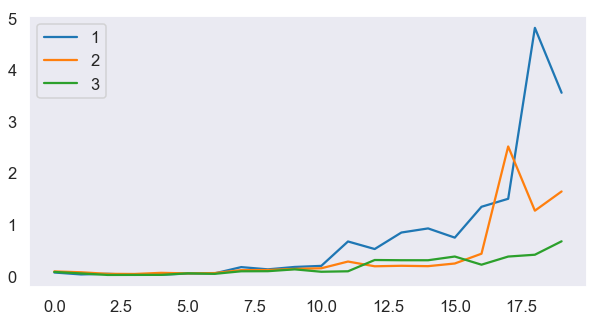

In [83]:
for npoly in range(1, 4):
    plt.plot(true_mse_det[npoly], label=str(npoly))
plt.legend()

In [69]:
p[npoly]

array([-0.30719474, -0.21119077])

In [70]:
init_p = InitP(p[npoly], [p[npoly]]*100)

In [71]:
enkf.initialize(init2level, np.array([1]*36 + [0.1]*360))

In [72]:
enkf.initialize_parameters(init_p, priors=-999, sigmas=-999)

In [73]:
enkf.l96_tru = L96TwoLevel(noprog=True, save_dt=0.01, noYhist=True, X_init=initX, Y_init=initY)

In [74]:
enkf.iterate(20)

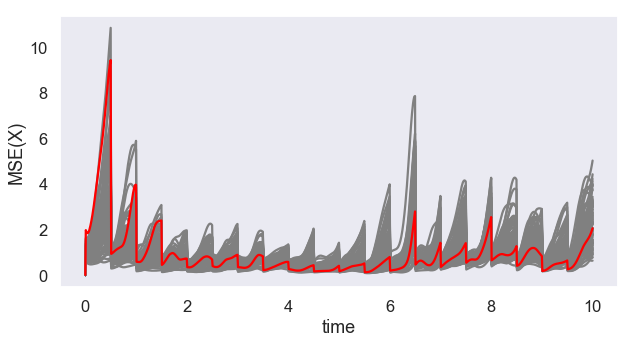

In [75]:
plot_mse(enkf)

In [76]:
enkf.mse_det

[0.9187248287630099,
 0.5803240217723398,
 0.4279634329821886,
 0.34297218421262265,
 0.40150175107988706,
 0.3394229365173132,
 0.2118601627408028,
 0.2623153077936544,
 0.1535249806666624,
 0.1547556927611833,
 0.12516582552939876,
 0.18581376366425217,
 0.4294319055047789,
 0.3318800720978173,
 0.5175929595331472,
 0.627824607937789,
 0.39442126583926707,
 0.1705732792365271,
 0.24314243990787768,
 0.1927424774377922]

## Create the wrong initial dataset

In [9]:
l96_wrong = L96TwoLevel(X_init=initX, Y_init=initY, F=10, h=1.5, c=7, b=5)

In [10]:
l96_wrong.iterate(20)

In [11]:
features_wrong = np.ravel(l96_wrong.history.X.values)
targets_wrong = np.ravel(l96_wrong.history.B.values)

## Create the wrong initial parameterizations

In [12]:
def create_wrong_params(npoly, nrand=100):
    p_wrong = np.polyfit(features_wrong, targets_wrong, npoly)
    p_ens = []
    n_ens = 100
    for i in range(n_ens):
        rand_idxs = np.random.randint(0, len(features_wrong), nrand)
        p_ens.append(np.polyfit(features_wrong[rand_idxs], targets_wrong[rand_idxs], npoly))
    return p_wrong, p_ens

In [42]:
for npoly in range(1, 7):
    p_wrong, p_ens = create_wrong_params(npoly)
    with open(f'{DIR}wrong_params_{npoly}.pkl', 'wb') as f: pickle.dump((p_wrong, p_ens), f) 

In [43]:
!ls $DIR

nwp_test.pkl	    wrong_params_2.pkl	wrong_params_4.pkl  wrong_params_6.pkl
wrong_params_1.pkl  wrong_params_3.pkl	wrong_params_5.pkl


In [32]:
with open(f'{DIR}nwp_test.pkl', 'rb') as f: 
    parameter_history_det, parameter_history_ens, mse_det, mse_ens = map(np.array, pickle.load(f))

In [33]:
np.array(parameter_history_ens).shape

(11, 100, 2)

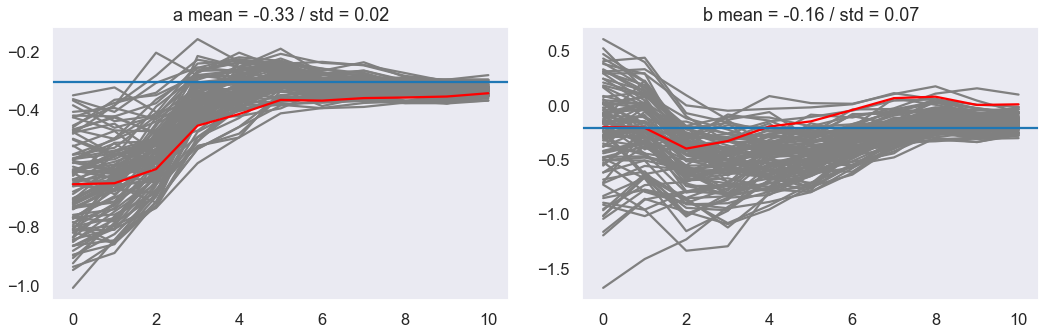

In [30]:
plot_params(det=parameter_history_det, ens=parameter_history_ens, names=['a', 'b'], truths=p[1])

In [34]:
mse_ens.shape

(10, 100)

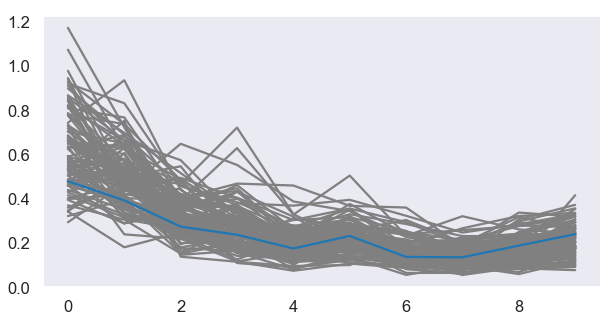

In [40]:
for m in mse_ens.T:
    plt.plot(m, c='gray')
plt.plot(mse_det)